In [ ]:
# ==========================================
# Title:  Banking marketing predictions
# Author: Magdalena Raczkiewicz
# Date:   22/03/2021
# ==========================================

## Banking marketing predictions


### Introduction to the analysis 
The aim of the following analysis is to identify customers that decided to subscribe for a term deposit and prove that obtained results are better than random selection of target group. Predictive Machine Learning model will be carried out. Then, assuming the total campaign budget is fixed, it is expected to calculate predicted lift from using the model.

In order to achieve that a bank marketing dataset has been made available, which contains attributes from the following categories:  

- Clients' data
- Target data  
- Data related with the last contact of the current campaign  
- Data about previous campaigns
- Social and economic context attributes  


  

### What is a term deposit?
It is a fixed-term investment that includes the deposit of money into an account at a financial institution. Term deposit investments usually carry short-term maturities ranging from one month to a few years
([link](https://www.investopedia.com/terms/t/termdeposit.asp)).  

### Proposed approach 
Calculation are being based on two groups: campaign (contacted customers) and control (not marketed). To achieve robust results an analytical approach has been proposed which consist of the following steps:  

1. Exploratory Data Analysis (correlations, distributions)
2. Dataset preparation for modelling (best sample balancing method)
3. Model the campain outcome using selected ML classification algorithms (Logistic Regression, SVC, Decision Tree, Random Forrest, Extra Trees, K-NN) 
4. Comparison of the models results and choosing the best model basing on ROC-AUC score with 5-fold Cross-Validation.  
5. Hyperparameter tuning for the best model
6. Evaluation of the results (recall, precision, f1 score, roc-auc, learning curves)  
7. Comparison of the model's results with the random selection from control group and showing expected lift 

In [ ]:
#@title 
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
import io

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import learning_curve
from sklearn.metrics import plot_confusion_matrix
from matplotlib.gridspec import GridSpec

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_recall_curve, recall_score, precision_score, classification_report

In [ ]:
#@title 
# function definitions 
def plot_roc_and_conf_matrix(clf, X, y, figure_size=(15, 5)):
    '''
    Plot both confusion matrix and ROC curce on the same figure.
    Parameters:
    -----------
    clf : sklearn.estimator
        model to use for predicting class probabilities.
    X : array_like
        data to predict class probabilities.
    y : array_like
        true label vector.
    figure_size : tuple (optional)
        size of the figure.
    Returns:
    --------
    plot : matplotlib.pyplot
        plot confusion matrix and ROC curve.
    '''
    # Compute tpr, fpr, auc and confusion matrix
    fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:, 1])
    auc = roc_auc_score(y, clf.predict_proba(X)[:, 1])
    conf_mat_clf = confusion_matrix(y, clf.predict(X), normalize='true')

    # Define figure size and figure ratios
    plt.figure(figsize=figure_size)
    gs = GridSpec(1, 2, width_ratios=(1, 2))

    # Plot confusion matrix
    ax0 = plt.subplot(gs[0])
    ax0.matshow(conf_mat_clf, cmap='coolwarm', alpha=0.2)

    for i in range(2):
        for j in range(2):
            value = round(conf_mat_clf[i, j], 2)
            ax0.text(x=j, y=i, s=value, ha="center", va="center")

    plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
    plt.xlabel("Predicted", fontdict={"fontsize": 14})
    plt.ylabel("Actual", fontdict={"fontsize": 14})

    # Plot ROC curce
    ax1 = plt.subplot(gs[1])
    ax1.plot(fpr, tpr, label="auc = {:.3f}".format(auc))
    plt.title("ROC curve", y=1, fontdict={"fontsize": 20})
    ax1.plot([0, 1], [0, 1], "r--")
    plt.xlabel("False positive rate", fontdict={"fontsize": 16})
    plt.ylabel("True positive rate", fontdict={"fontsize": 16})
    plt.legend(loc="lower right", fontsize="medium")

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       scoring='f1',
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(sorted(fit_times_mean), sorted(test_scores_mean), 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
# setting the theme 
sns.set_theme()

In [ ]:
# importing the file
uploaded = files.upload()
raw_data = pd.read_csv(io.BytesIO(uploaded['bank_data_prediction_task.csv']))
df = raw_data.copy()
df = df.drop('Unnamed: 0', axis=1)

Saving bank_data_prediction_task.csv to bank_data_prediction_task.csv


## Exploratory Data Analysis

In [ ]:
#@title  
# dataset exploration
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,test_control_flag
0,37,services,married,high.school,no,yes,no,telephone,may,mon,226.0,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
1,56,services,married,high.school,no,no,yes,telephone,may,mon,307.0,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
2,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217.0,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes,campaign group
3,25,services,single,high.school,no,yes,no,telephone,may,mon,50.0,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
4,25,services,single,high.school,no,yes,no,telephone,may,mon,222.0,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group


In [ ]:
# splitting into campaign and control groups
df_campaign = df.loc[df.test_control_flag == 'campaign group'].drop('test_control_flag', axis=1)
df_control = df.loc[df.test_control_flag == 'control group'].drop('test_control_flag', axis=1)

In [ ]:
df_campaign.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16476 entries, 0 to 16475
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             16476 non-null  int64  
 1   job             16476 non-null  object 
 2   marital         16476 non-null  object 
 3   education       16476 non-null  object 
 4   default         16476 non-null  object 
 5   housing         16476 non-null  object 
 6   loan            16476 non-null  object 
 7   contact         16476 non-null  object 
 8   month           16476 non-null  object 
 9   day_of_week     16476 non-null  object 
 10  duration        16476 non-null  float64
 11  campaign        16476 non-null  float64
 12  pdays           16476 non-null  int64  
 13  previous        16476 non-null  int64  
 14  poutcome        16476 non-null  object 
 15  emp.var.rate    16476 non-null  float64
 16  cons.price.idx  16476 non-null  float64
 17  cons.conf.idx   16476 non-null 

In [ ]:
df_control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24712 entries, 16476 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24712 non-null  int64  
 1   job             24712 non-null  object 
 2   marital         24712 non-null  object 
 3   education       24712 non-null  object 
 4   default         24712 non-null  object 
 5   housing         24712 non-null  object 
 6   loan            24712 non-null  object 
 7   contact         0 non-null      object 
 8   month           0 non-null      object 
 9   day_of_week     0 non-null      object 
 10  duration        0 non-null      float64
 11  campaign        0 non-null      float64
 12  pdays           24712 non-null  int64  
 13  previous        24712 non-null  int64  
 14  poutcome        24712 non-null  object 
 15  emp.var.rate    24712 non-null  float64
 16  cons.price.idx  24462 non-null  float64
 17  cons.conf.idx   24712 non-n

Campaign group does not contain missing values. Control gorup, contains missing values in *cons.price.idx* column - they are going to be replaced by mean of the whole group. All columns regarding last contact in control group are expected to be empty since those customers weren't a part of the campaign.  

Keeping in mind that the objective of the analysis is to identify customers for which the gain from being contacted is the highest, **data related to last contact won't be considered from this point forward** - this information is unknown before the actual call is performed and cannot be used in realistic model.

In [ ]:
# dropping contact data
df_campaign = df_campaign.drop(['contact', 'month', 'day_of_week', 'duration', 'campaign'], axis=1)
df_control = df_control.drop(['contact', 'month', 'day_of_week', 'duration', 'campaign'], axis=1)

# filling missing values
df_control = df_control.fillna(df_control.mean())

In [ ]:
#@title 
# campain group exploration
df_campaign.describe()

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,16476.000000,16476.000000,16476.000000,16476.000000,16476.000000,16476.000000,16476.000000,16476.000000
mean,39.987922,962.779983,0.172675,0.078253,93.573239,-40.530681,3.616076,5166.873908
std,10.488565,186.159341,0.491860,1.570667,0.577235,4.636000,1.736256,72.211048
min,17.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,94.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


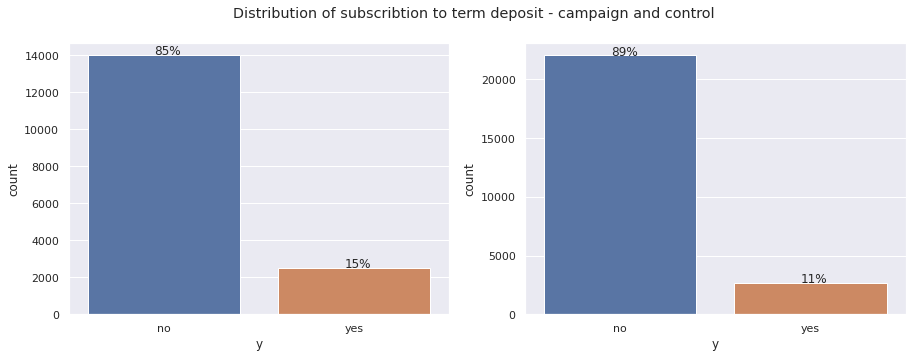

In [ ]:
#@title  
# zoom into the explained variable 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Distribution of subscribtion to term deposit - campaign and control')
sns.countplot(x='y', data=df_campaign, ax=ax1)  
for p in ax1.patches:
        ax1.annotate('{:.0f}%'.format(p.get_height()/len(df_campaign)*100), (p.get_x()+0.35, p.get_height()+51))
sns.countplot(x='y', data=df_control, ax=ax2) 
for p in ax2.patches:
        ax2.annotate('{:.0f}%'.format(p.get_height()/len(df_control)*100), (p.get_x()+0.35, p.get_height()+51))

plt.show()

On average campaign activities enables to obtain 4% more customers. 

### Categorical features - campaign group


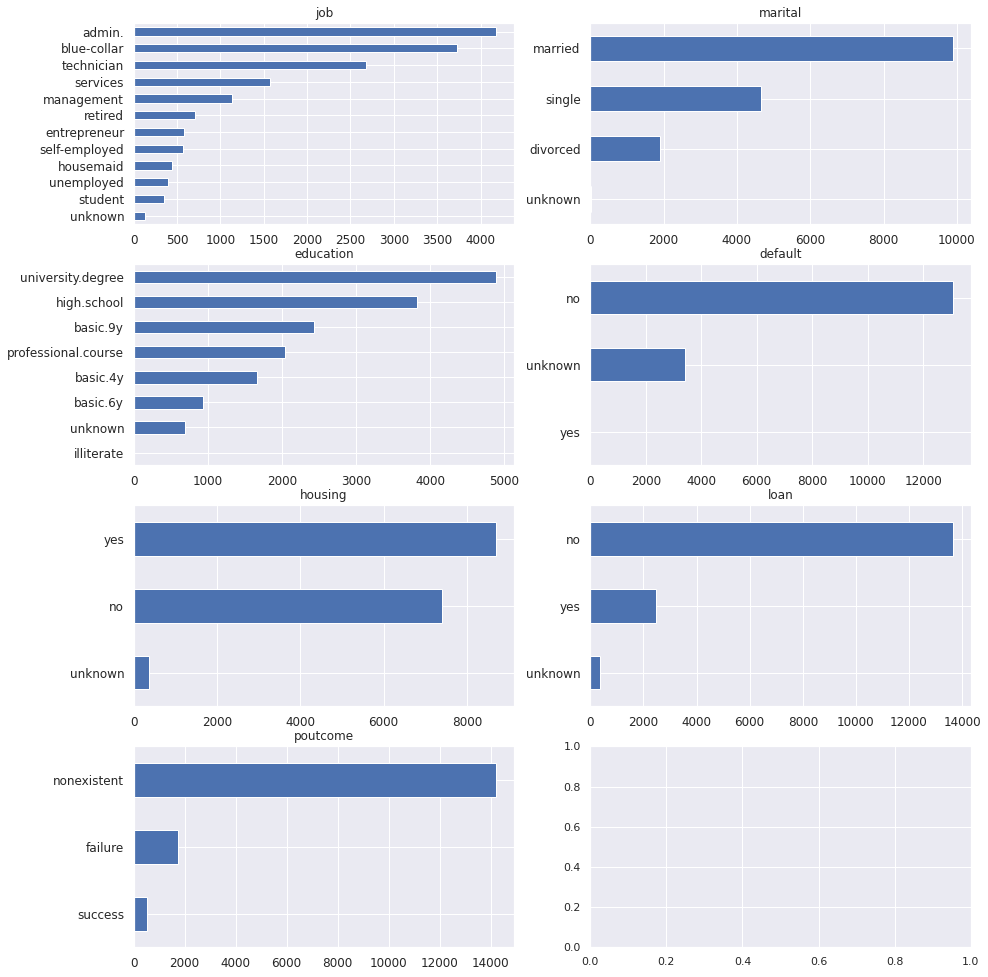

In [ ]:
#@title 
# univariate 
cat_cols = [df_campaign.columns[i] 
            for i in range(1, df_campaign.shape[1]-1)  
            if df_campaign.iloc[:,i].dtype=='O']
cat_cols

fig, axes = plt.subplots(4, 2, figsize=(15,17))
axes = [ax for axes_rows in axes for ax in axes_rows]

for i, c in enumerate(df_campaign[cat_cols]):
    df_campaign[c].value_counts()[::-1].plot(kind='barh',
                                          ax=axes[i],
                                          title=c,
                                          fontsize=12)

In [ ]:
# y as numeric column
df_campaign.y = df_campaign.y.map({'no':0, 'yes':1}).astype('uint8')

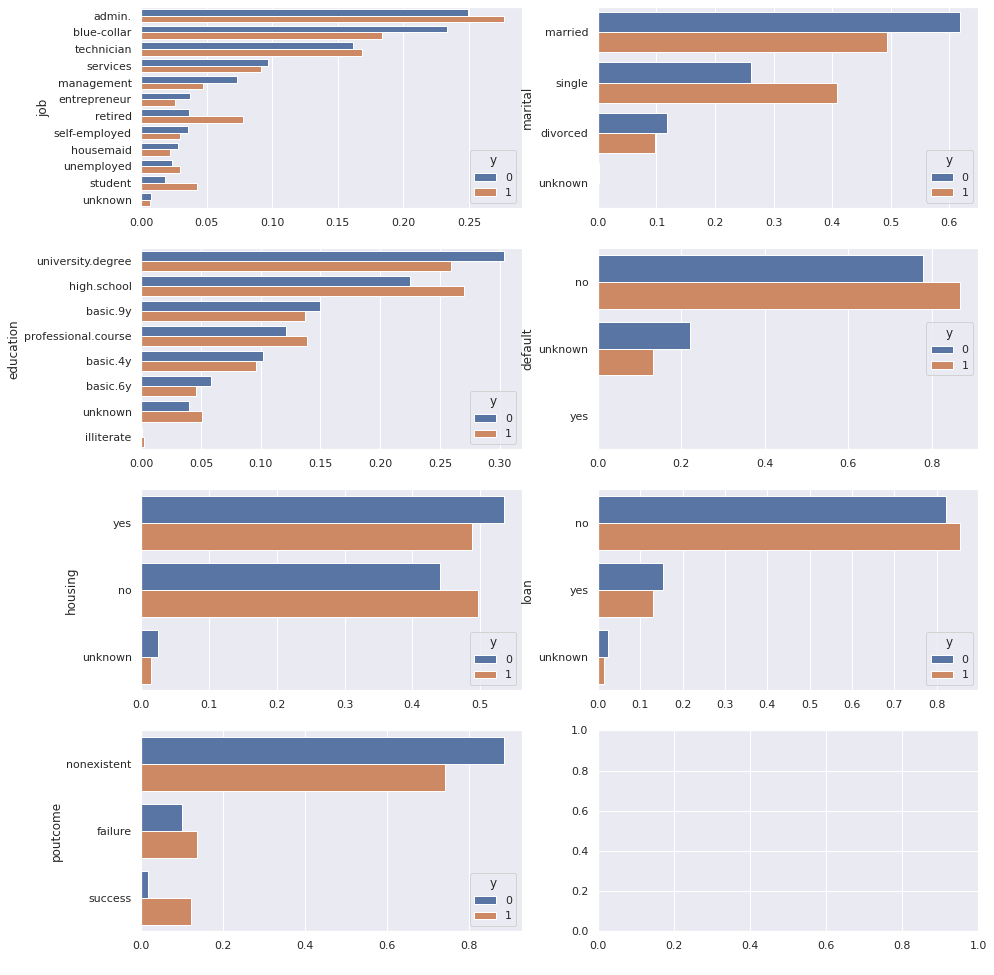

In [ ]:
#@title  
# bivariate
fig, axes = plt.subplots(4, 2, figsize=(15,17))
axes = [ax for axes_rows in axes for ax in axes_rows]

for i, c in enumerate(df_campaign[cat_cols]):
    fltr = df_campaign['y']==0
    vc_a = df_campaign[fltr][c].value_counts(normalize=True).reset_index().rename({'index':c,c:' '}, axis=1)
    vc_b = df_campaign[~fltr][c].value_counts(normalize=True).reset_index().rename({'index':c,c:' '}, axis=1)

    vc_a['y']=0
    vc_b['y']=1
    
    df_box = pd.concat([vc_a, vc_b]).reset_index(drop=True)
    sns.barplot(y=c, x=' ', data=df_box, hue='y', ax=axes[i])

Observations:  
 1. Working groups in which ratio for successful outcome is the highest are students and retired people.
 2. Singles are more likely to subscribe for term deposit.
 3. Customers with successfull outcome of the previous campain are only a small percentage of the whole group, but it is very likely that they will subscribe again.
 4. In the dataset there are no missing values but there are 'unknown' values. They are going to be replaced by the mode for each variable.  


In [ ]:
# filling unknown categorical values
df_campaign = df_campaign.replace('unknown', np.nan).fillna(df_campaign.mode().iloc[0])
df_control = df_control.replace('unknown', np.nan).fillna(df_control.mode().iloc[0])

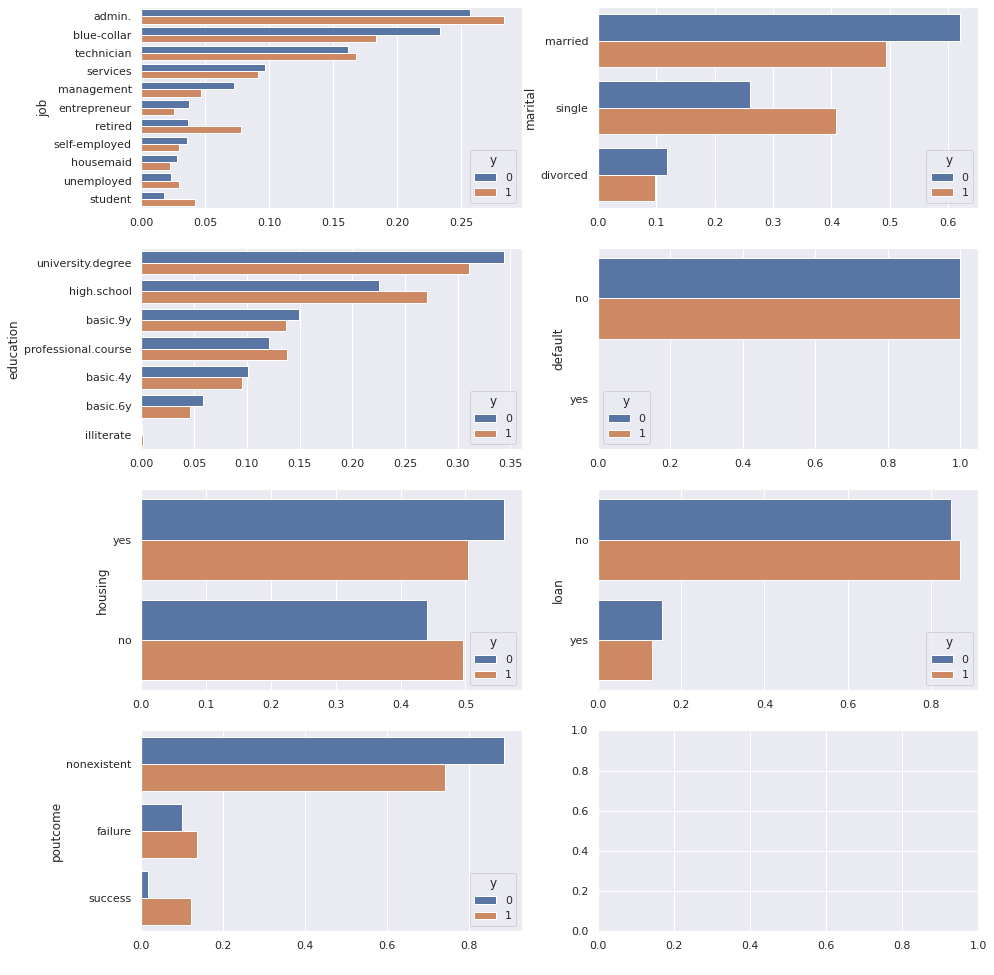

In [ ]:
#@title  
# bivariate aften unknown fill
fig, axes = plt.subplots(4, 2, figsize=(15,17))
axes = [ax for axes_rows in axes for ax in axes_rows]

for i, c in enumerate(df_campaign[cat_cols]):
    fltr = df_campaign['y']==0
    vc_a = df_campaign[fltr][c].value_counts(normalize=True).reset_index().rename({'index':c,c:' '}, axis=1)
    vc_b = df_campaign[~fltr][c].value_counts(normalize=True).reset_index().rename({'index':c,c:' '}, axis=1)

    vc_a['y']=0
    vc_b['y']=1
    
    df_box = pd.concat([vc_a, vc_b]).reset_index(drop=True)
    sns.barplot(y=c, x=' ', data=df_box, hue='y', ax=axes[i])


### Numerical features - campaign group

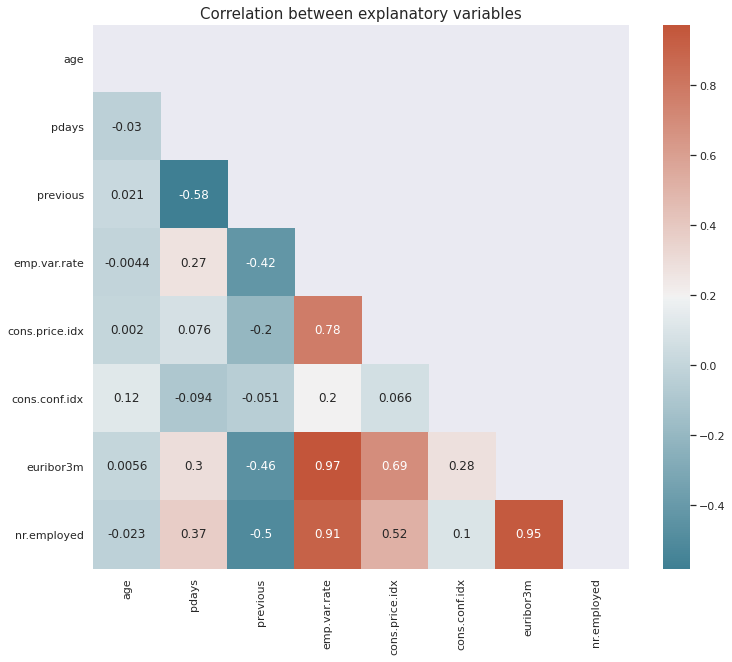

In [ ]:
#@title  
# heatmap corr check
fig, ax = plt.subplots(figsize=(12, 10))

corr = df_campaign.drop('y', axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
fig = sns.heatmap(corr, annot=True, mask=mask, cmap=sns.diverging_palette(220, 20, as_cmap=True))
ax.set_title("Correlation between explanatory variables", fontsize = 15)
plt.show()

Point-biserial correlation between binary and continuous variables 

In [ ]:
#@title  
# calculate point-biserial correlation between binary and continuous variables 
from scipy import stats

num_cols = ['age', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']
corr_list = []
p_val_list = []

for col in num_cols:
  corr_list.append(stats.pointbiserialr(df_campaign['y'], df_campaign[col])[0])
  p_val_list.append(stats.pointbiserialr(df_campaign['y'], df_campaign[col])[1])

corr_df = pd.DataFrame(list(zip(num_cols, corr_list, p_val_list)), columns = ['feature', 'correlation', 'p_value'])
corr_df.sort_values(by='correlation', ascending=False)                       

,feature,correlation,p_value
2,previous,0.175909,1.266416e-114
0,age,0.002539,7.445021e-01
4,cons.price.idx,-0.086526,9.326123e-29
3,emp.var.rate,-0.206111,1.538740e-157
5,euribor3m,-0.217425,1.644931e-175
1,pdays,-0.223795,4.316781e-186
6,nr.employed,-0.251161,1.997448e-235


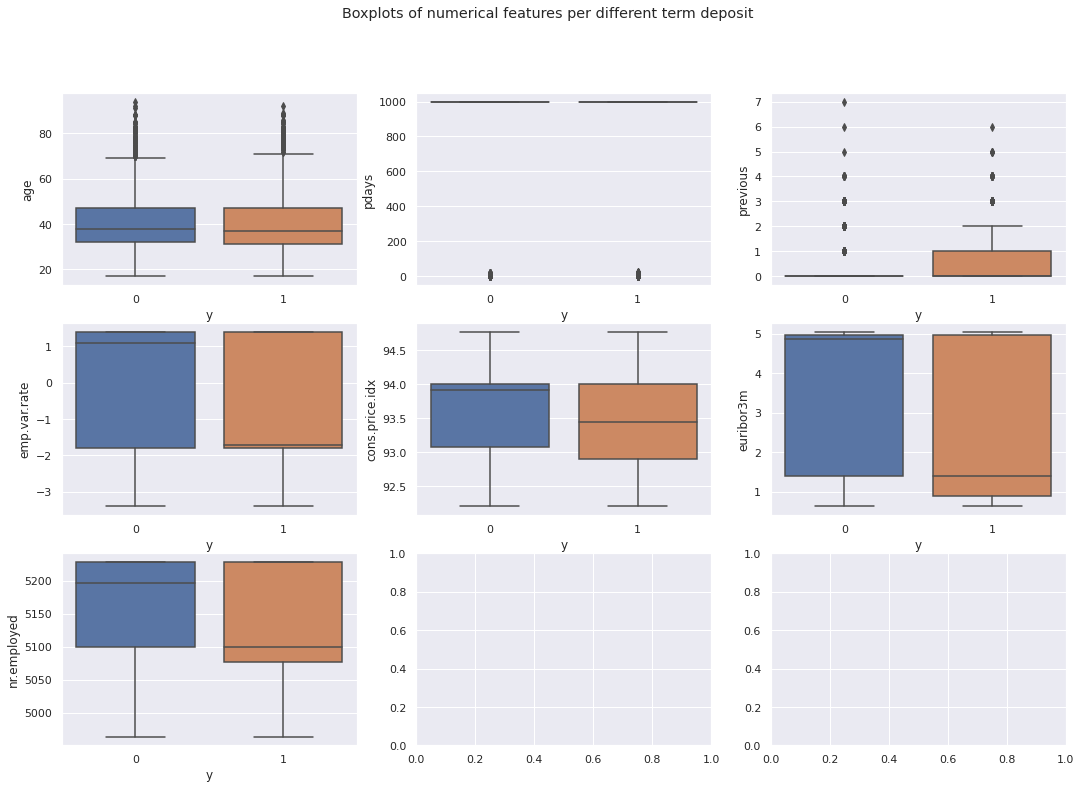

In [ ]:
#@title  
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))

fig.suptitle('Boxplots of numerical features per different term deposit')
sns.boxplot(x='y', y='age', data=df_campaign, ax=ax1)  
sns.boxplot(x='y', y='pdays', data=df_campaign, ax=ax2)
sns.boxplot(x='y', y='previous', data=df_campaign, ax=ax3)
sns.boxplot(x='y', y='emp.var.rate', data=df_campaign, ax=ax4)
sns.boxplot(x='y', y='cons.price.idx', data=df_campaign, ax=ax5)
sns.boxplot(x='y', y='euribor3m', data=df_campaign, ax=ax6)
sns.boxplot(x='y', y='nr.employed', data=df_campaign, ax=ax7)

plt.show()

Observations:  
1. Feature that has the highest positive correlation with subscription to the term deposit (y) is *previous* (number of contacts performed before this campaign and for this client) the more we used to call the more a customer is likely to subscribe for term deposit. 
2. The least correlated feature is *age*. Boxplots confirmed that difference in terms of age in both group is very small.
3. 4 out of 5 features from social and economic context group are negatively correlated with explained variable.
4. Since *emp.var.rate*, *euribor3m* and *nr.employed* are very highly correlated with each other it was decided to keep only one, the most correlated with target value - *nr.employed*.
5. It was decided to convert *age* to categorical variable for easier result interpretation. 

## Preparation for modelling

In [ ]:
# convert age to categorical
df_campaign['age'] = pd.cut(df_campaign.age,bins=[0,24,35,50,99],labels=['student','young_adult','adult','elderly'])

In [ ]:
# removing overly correlated features
df_campaign = df_campaign.drop(['emp.var.rate', 'euribor3m'], axis=1)

In [ ]:
# one-hot encoding 
df_encoded = pd.get_dummies(df_campaign, columns=['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome'], drop_first=True)
df_encoded.head()

,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,y,age_young_adult,age_adult,age_elderly,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,poutcome_nonexistent,poutcome_success
0,999,0,93.994,-36.4,5191.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0
1,999,0,93.994,-36.4,5191.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0
2,999,0,93.994,-36.4,5191.0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,999,0,93.994,-36.4,5191.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0
4,999,0,93.994,-36.4,5191.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0


## Modelling

In [ ]:
# dataset split (with stratify to reduce class imbalance)
from sklearn.model_selection import train_test_split

X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [ ]:
#@title  
# oversampling minority class
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

X_train_up, y_train_up = resample(X_train[y_train == 1],
                                  y_train[y_train == 1],
                                  replace=True,
                                  n_samples=X_train[y_train == 0].shape[0],
                                  random_state=1)

X_train_up = pd.concat([X_train[y_train == 0], X_train_up])
y_train_up = pd.concat([y_train[y_train == 0], y_train_up])

# downsampling majority class
X_train_dw, y_train_dw = resample(X_train[y_train == 0],
                                  y_train[y_train == 0],
                                  replace=True,
                                  n_samples=X_train[y_train == 1].shape[0],
                                  random_state=1)

X_train_dw = pd.concat([X_train[y_train == 1], X_train_dw])
y_train_dw = pd.concat([y_train[y_train == 1], y_train_dw])

# SMOTE - synthetic oversampling
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train) 

In [ ]:
# check the shapes of the classes
print("Original shape:", X_train.shape, y_train.shape)
print("Oversampled shape:", X_train_up.shape, y_train_up.shape)
print("Downsampled shape:", X_train_dw.shape, y_train_dw.shape)
print("SMOTE shape:", X_train_smote.shape, y_train_smote.shape)

Original shape: (13180, 31) (13180,)
Oversampled shape: (22386, 31) (22386,)
Downsampled shape: (3974, 31) (3974,)
SMOTE shape: (22386, 31) (22386,)


In [ ]:
# choose sample balancing method 
# X_train, y_train = X_train_up.copy(), y_train_up.copy()
X_train, y_train = X_train_dw.copy(), y_train_dw.copy()
# X_train, y_train = X_train_smote.copy(), y_train_smote.copy()

Text(0.5, 1.0, 'CV Scores')

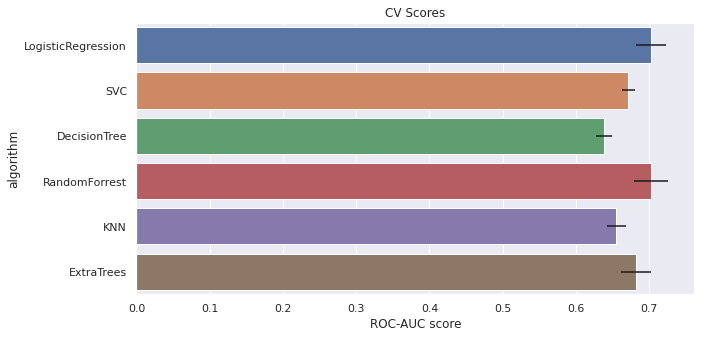

In [ ]:
#@title  
# check selected ML algorithms - roc-auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV, cross_validate

clfs = []
clfs.append(LogisticRegression(random_state=42))
clfs.append(SVC(random_state=42))
clfs.append(DecisionTreeClassifier(random_state=42))
clfs.append(RandomForestClassifier(random_state=42))
clfs.append(KNeighborsClassifier())
clfs.append(ExtraTreesClassifier(random_state=42))

cv_results = []

for clf in clfs:
    result = cross_val_score(clf, X_train, y_train,
                             scoring='roc_auc', cv=5, n_jobs=-1)

    cv_results.append(result)

# plot the CV results
cv_means = []
cv_stds = []

for result in cv_results:
    cv_means.append(result.mean())
    cv_stds.append(result.std())

algs = ['LogisticRegression', 'SVC', 'DecisionTree',
        'RandomForrest', 'KNN', 'ExtraTrees']

df_results = pd.DataFrame(
    {'cv_mean': cv_means, 'cv_std': cv_stds, 'algorithm': algs})

plt.figure(figsize=(10,5))
g = sns.barplot('cv_mean', 'algorithm', data=df_results, orient='h', xerr=cv_stds)

g.set_xlabel('ROC-AUC score')
g.set_title('CV Scores')

Out of all tested algorithms Logistic Regression and Random Forest Classifier seemed to be the most effective ones (based on ROC-AUC score). Random Forest is going to be developed further in the next step of finding the optimal parameters since it is not sensitive to unscaled data  - that other distance/curve based classifiers (Logistic Regression, SVC, k-NN) are vounerable to.

In [ ]:
#@title  
# Random Forest Classifier - hyperparameter tuning
from sklearn.pipeline import make_pipeline

pip_rf = make_pipeline(RandomForestClassifier(class_weight='balanced',
                                              random_state=42))

n_estimators = [int(n) for n in np.linspace(100, 800, 20)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(n) for n in np.linspace(3, 7, 5)]
max_depth.append(None)
min_samples_split = [0, 5, 10]
min_samples_leaf = [0, 5, 4]
bootstrap = [True, False]
n_iter_search = 25

rf_params = {'randomforestclassifier__n_estimators': n_estimators,
             'randomforestclassifier__max_features': max_features,
             'randomforestclassifier__max_depth': max_depth,
             'randomforestclassifier__min_samples_split': min_samples_split,
             'randomforestclassifier__min_samples_leaf': min_samples_leaf,
             'randomforestclassifier__bootstrap': bootstrap
             }

rs_rf = RandomizedSearchCV(pip_rf,
                           param_distributions=rf_params,
                           scoring='roc_auc',
                           cv=5,
                           n_jobs=-1,
                           refit=True,
                           iid=False,
                           n_iter=n_iter_search
                           )

rs_rf.fit(X_train, y_train)

print("The best hyperparameters:")
print("-" * 25)

for hyperparam in rs_rf.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:],
          ": ", rs_rf.best_params_[hyperparam])

print('The 5-fold CV roc-auc score is: {:.2f}%'.format(
    np.mean(rs_rf.best_score_) * 100))


The best hyperparameters:
-------------------------
n_estimators :  136
min_samples_split :  10
min_samples_leaf :  5
max_features :  auto
max_depth :  None
bootstrap :  False
The 5-fold CV roc-auc score is: 73.21%


## Evaluation of the results

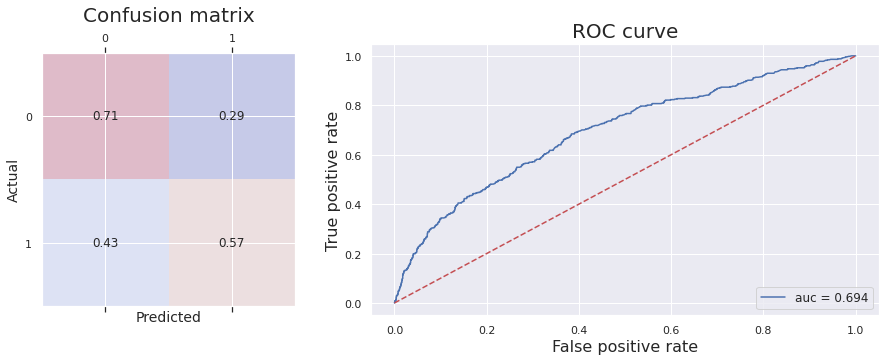

In [ ]:
#@title  
# RF - pipeline - model with best scores
pipeline = make_pipeline(RandomForestClassifier(n_estimators=763,
                                                min_samples_split=10,
                                                min_samples_leaf=5,
                                                max_features='log2',
                                                max_depth=None,
                                                bootstrap=True,
                                                class_weight='balanced',
                                                n_jobs=-1,
                                                random_state=42))
                                                
rf = pipeline.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

plot_roc_and_conf_matrix(pipeline, X_test, y_test)

In [ ]:
#@title  
# best model measures
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      2799
           1       0.26      0.57      0.35       497

    accuracy                           0.69      3296
   macro avg       0.58      0.64      0.57      3296
weighted avg       0.81      0.69      0.73      3296



Since as a performance measure, accuracy is inappropriate for imbalanced classification problems model assessment was based mostly on ROC-AUC and Recall scores (because the objective is to minimaze the FN).  It is clear that model's performance is far from ideal - number of FN is very high. Proposed solutions are presented in the final part.  

Text(0.5, 1.0, 'Feature importance')

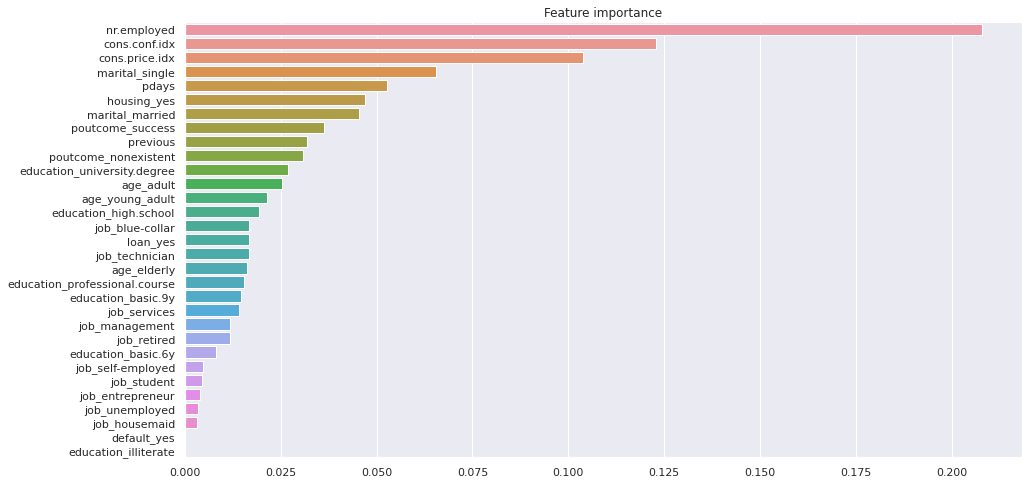

In [ ]:
#@title  
# plot feature importance 
plt.figure(figsize=(15,8))
important_features = pd.Series(data = pipeline.steps[0][1].feature_importances_, index=X.columns)
important_features.sort_values(ascending=False, inplace=True)

_ = sns.barplot(x=important_features.values, y=important_features.index, orient='h')

plt.title("Feature importance")

Conclusions:
1. As expected economic context features (regarding employment rate, price index, consumer confidence index) have high impact on the model's decision.
2. Features that can indicate target group for the next campaign: single marital status, customers that have housing or private loan, number of contacts performed before this campaign and for this client, successful outcome of the previous campaign, higher education and high number of calls in the previous campaign if applicable.


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

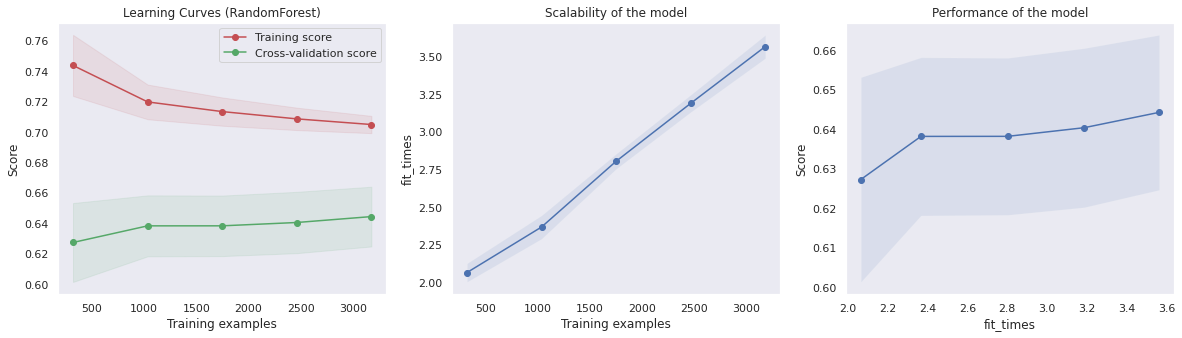

In [ ]:
#@title  
# plotting learning curves
from sklearn.model_selection import ShuffleSplit
# score curves, each time with 20% data randomly selected as a validation set
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
estimator = pipeline

plot_learning_curve(estimator, title="Learning Curves (RandomForest)", X=X_train, y=y_train, cv=cv, n_jobs=-1)

RF model learning curves indicate decreasing variance (gap between train and cv scores). Both the validation score and the training score points to a value that is quite low considering increasing size of the training set. Thus, it is unlikely to benefit much from more training data.

Comparison with control group 

In [ ]:
#@title  
# prep for modelling
df_pred = df_control.drop(['emp.var.rate', 'euribor3m'], axis=1)
df_pred['age'] = pd.cut(df_pred.age,bins=[0,24,35,50,99],labels=['student','young_adult','adult','elderly'])
df_pred.y = df_pred.y.map({'no':0, 'yes':1}).astype('uint8')
df_pred = pd.get_dummies(df_pred, columns=['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome'], drop_first=True)

y_actual = df_pred.y.reset_index(drop=True)
df_pred = df_pred.drop('y', axis=1)

In [ ]:
# running model on control group
y_predicted = pd.DataFrame(rf.predict(df_pred))
df_results = pd.concat([y_actual.reset_index(drop=True), y_predicted], axis=1)
df_results.columns = ['random_deposit', 'predicted_deposit']

Text(0, 0.5, 'Random')

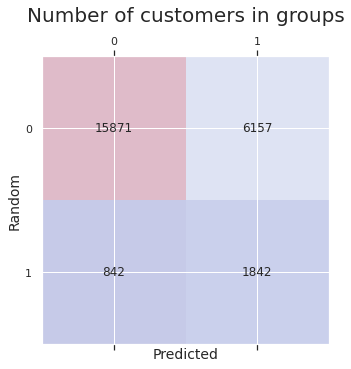

In [ ]:
#@title  
# results presentation in a confusion matrix format
figure_size=(17, 7)
plt.figure(figsize=figure_size)
gs = GridSpec(1, 2, width_ratios=(1, 2))

conf_mat_clf = confusion_matrix(df_results[['random_deposit']], df_results[['predicted_deposit']])

# Plot confusion matrix
ax0 = plt.subplot(gs[0])
ax0.matshow(conf_mat_clf, cmap='coolwarm', alpha=0.2)

for i in range(2):
    for j in range(2):
        value = round(conf_mat_clf[i, j], 2)
        ax0.text(x=j, y=i, s=value, ha="center", va="center")

plt.title("Number of customers in groups", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Random", fontdict={"fontsize": 14})

In [ ]:
#@title  
print(classification_report(df_results[['random_deposit']], df_results[['predicted_deposit']]))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     22028
           1       0.23      0.69      0.34      2684

    accuracy                           0.72     24712
   macro avg       0.59      0.70      0.58     24712
weighted avg       0.87      0.72      0.77     24712



Model output aligned with random decisions of customers in 72%.
Expected lift will be calculated as difference between customers who are predicted to subscribe and the one that subscribed in real life but wasn't highited by the model (FP-FN).   

In [ ]:
#@title  
# calculating expected lift 
df_results = df_results.astype(int)
print("Expected lift from targeting the right group based on model's performance: %.2f" % (df_results.sum()[1]/df_results.sum()[0]))

Calculated value indicates **2.98 lift** in number of customers who successfully subscribed for term deposit. Meaning that if all of the highlited by the model customers wll be addressed number of subscribers is going to be almost 3 times bigger.  
In reality such a positive scenario is almost impossible. Also, model's precision is still an area of developement and customer can always decline the offer due to random events. Hence, it is expected that the final lift outcome is going to be reduced to assumed level.

## Proposed next steps

1. Perform PCA to indicate key components.
2. Explore other algorithms to improve the score (Logistic Regression, Ada Boost Classifier, Linear Discriminant Analysis, Neural Networks).
3. Check other features that might be relevant (for e.g. loaction, size of the family).